In [1]:
#Import relevant libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #nicer rendering of plots in retina displays

import sys
print(sys.version)

import numpy as np
print ('Numpy version:', np.__version__)

import pandas as pd
print ('Pandas version:', pd.__version__)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
print ('Matplotlib version:', mpl.__version__)

import plotly.graph_objs as go 
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

import seaborn as sns
sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

import re

3.6.3 |Anaconda, Inc.| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
Numpy version: 1.13.3
Pandas version: 0.20.3
Matplotlib version: 2.1.0


# Analyzing the Impact of the Affordable Care Act

The Affordable Care Act (ACA) is the name for the comprehensive health care reform law and its amendments which addresses health insurance coverage, health care costs, and preventive care. The law was enacted in two parts: The Patient Protection and Affordable Care Act was signed into law on March 23, 2010 by President Barack Obama and was amended by the Health Care and Education Reconciliation Act on March 30, 2010.

A repeal of the ACA was recently approved by the Congress. This analysis aims to expose metrics to quantify the impact of the ACA.

In [2]:
%ls Data/

Invalid switch - "".


# Load and process dataset with information before the ACA (1995-2010)

In [3]:
#Source: https://www.kaggle.com/cdc/health-care-access-coverage
#The health insurance coverage data was compiled from the US Department of Health and Human Services and 
#US Census Bureau. It seems to relate to surveys, maybe the American Community Survey? 

pre_ACA = pd.read_csv('Data/HC_access_1995-2010.csv')

In [4]:
pre_ACA.head(5)

,Year,State,Yes,No,Category,Condition,Location 1
0,2010,"Nationwide (States, DC, and Territories)",85%,15%,Health Care Access/Coverage,Do you have any kind of health care coverage?,"Nationwide (States, DC, and Territories)\n"
1,2010,Nationwide (States and DC),85%,15%,Health Care Access/Coverage,Do you have any kind of health care coverage?,Nationwide (States and DC)\n
2,2010,Guam,77.80%,22.20%,Health Care Access/Coverage,Do you have any kind of health care coverage?,Guam\n
3,2010,Puerto Rico,92.10%,7.90%,Health Care Access/Coverage,Do you have any kind of health care coverage?,Puerto Rico\n
4,2010,Virgin Islands,69.40%,30.60%,Health Care Access/Coverage,Do you have any kind of health care coverage?,Virgin Islands\n


In [5]:
#Remove % from string values
pre_ACA['Yes'] = pre_ACA.Yes.apply(lambda x: re.sub('%', '', x))
pre_ACA['No'] = pre_ACA.No.apply(lambda x: re.sub('%', '', x))

In [6]:
#Get geolocation
pre_ACA['geolocation'] = pre_ACA['Location 1'].apply(lambda x: x.split('\n')[1].split(','))

In [7]:
#Get latitude from geolocation
pre_ACA['lat'] = pre_ACA.geolocation.apply(lambda x: re.sub('\(', '', x[0]))

In [8]:
def get_long(x):
    return re.sub('\)|\s', '', x[1]) if len(x)>1 else ''

In [9]:
#Get longitude from geolocation
pre_ACA['long'] = pre_ACA.geolocation.apply(lambda x: get_long(x))

In [10]:
#Drop redundant columns
pre_ACA = pre_ACA.drop('geolocation', axis=1)
pre_ACA = pre_ACA.drop('Location 1', axis=1)

In [11]:
#Convert string datatypes to numeric
for col in ['Yes', 'No', 'lat', 'long']:
    pre_ACA[col] = pd.to_numeric(pre_ACA[col])

In [12]:
pre_ACA.tail()

,Year,State,Yes,No,Category,Condition,lat,long
1635,2010,Alabama,79.9,20.1,Health Care Access/Coverage,Adults aged 18-64 who have any kind of health ...,32.840571,-86.631861
1636,1996,Mississippi,82.7,17.3,Health Care Access/Coverage,Adults aged 18-64 who have any kind of health ...,32.745510,-89.538031
1637,1996,Virginia,85.4,14.6,Health Care Access/Coverage,Do you have any kind of health care coverage?,37.542681,-78.457890
1638,2006,Wyoming,82.1,17.9,Health Care Access/Coverage,Do you have any kind of health care coverage?,43.235541,-108.109830
1639,1996,Tennessee,86.1,13.9,Health Care Access/Coverage,Adults aged 18-64 who have any kind of health ...,35.680941,-85.774491


In [13]:
pre_ACA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 8 columns):
Year         1640 non-null int64
State        1640 non-null object
Yes          1640 non-null float64
No           1640 non-null float64
Category     1640 non-null object
Condition    1640 non-null object
lat          1522 non-null float64
long         1522 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 102.6+ KB


In [14]:
len(sorted(pre_ACA.State.unique()))#50 states + DC + PR, Guam, VI + 2 Nationwide values

56

In [15]:
pre_ACA.Year.unique()

array([2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000,
       1999, 1998, 1997, 1996, 1995], dtype=int64)

In [16]:
pre_ACA.Condition.unique()

array(['Do you have any kind of health care coverage?',
       'Adults aged 18-64 who have any kind of health care coverage'], dtype=object)

In [17]:
pre_ACA.Category.unique() #redundant

array(['Health Care Access/Coverage'], dtype=object)

In [18]:
#It's not clear how the 2 different categories differ. For this reason, I will work with the category
#'Do you have any kind of health care coverage?' because it's not limited by the age group between 18 and 64.
pre_ACA[pre_ACA.Condition == 'Do you have any kind of health care coverage?'][['Yes', 'No']].describe()

,Yes,No
count,876.000000,876.000000
mean,85.830251,14.169977
std,4.442541,4.442488
min,69.000000,4.300000
25%,83.000000,10.900000
50%,86.400000,13.600000
75%,89.100000,17.000000
max,95.700000,31.000000


In [19]:
#Print stats for comparison.
pre_ACA[pre_ACA.Condition != 'Do you have any kind of health care coverage?'][['Yes', 'No']].describe()

,Yes,No
count,764.000000,764.000000
mean,83.317408,16.683377
std,5.073509,5.073334
min,65.900000,5.000000
25%,80.000000,13.000000
50%,84.000000,16.000000
75%,87.000000,20.000000
max,95.000000,34.100000


In [20]:
#Select a subset of the data
subset = pre_ACA[(pre_ACA.State.str.contains('Nationwide') == False)\
        & (pre_ACA.Condition == 'Do you have any kind of health care coverage?')] #844 rows

In [21]:
#Drop redundant columns
subset = subset.drop('Category', axis=1)
subset = subset.drop('Condition', axis=1)

In [22]:
#Load file with state codes
state_codes = pd.read_csv('Data/state_codes.csv')
state_codes = state_codes[['code','state']]
state_codes.columns = ['code', 'State']
state_codes.tail()

,code,State
49,WY,Wyoming
50,DC,District of Columbia
51,PR,Puerto Rico
52,GU,Guam
53,VI,Virgin Islands


In [23]:
#Merge state code into dataset
subset= subset.merge(state_codes, how='left', on='State')

In [24]:
#Check data
subset[23:38]

,Year,State,Yes,No,lat,long,code
23,2002,Virgin Islands,69.0,31.0,NaN,NaN,VI
24,2001,Guam,81.4,18.6,NaN,NaN,GU
25,2001,Puerto Rico,91.5,8.5,NaN,NaN,PR
26,2001,Virgin Islands,71.7,28.3,NaN,NaN,VI
27,2000,Puerto Rico,91.0,9.0,NaN,NaN,PR
28,1999,Puerto Rico,88.3,11.7,NaN,NaN,PR
29,1998,Puerto Rico,89.0,11.0,NaN,NaN,PR
30,1997,Puerto Rico,89.7,10.3,NaN,NaN,PR
31,1996,Puerto Rico,86.4,13.6,NaN,NaN,PR
32,2007,Virginia,88.2,11.8,37.542681,-78.457890,VA


In [25]:
#Create pivot table with percentage of insured people per state per year
has_insurance = subset.pivot('code','Year','Yes')
has_insurance.head(10)

Year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
code,,,,,,,,,,,,,,,,
AK,84.7,79.2,78.7,79.2,76.7,81.9,81.2,80.9,82.5,83.5,82.9,82.5,84.8,82.9,82.3,82.4
AL,85.7,84.0,85.6,83.6,84.9,83.9,85.0,84.9,85.4,82.9,83.1,84.0,85.3,84.0,84.5,83.8
AR,84.6,82.1,82.7,84.5,83.9,82.8,83.9,81.1,80.8,81.4,80.8,79.4,79.7,81.7,80.0,78.7
AZ,84.8,83.0,85.4,86.8,85.8,82.9,83.1,83.9,83.3,82.1,79.1,80.4,81.9,82.2,85.0,86.7
CA,80.5,80.5,80.7,81.9,80.7,81.6,85.0,84.6,83.9,82.7,82.8,82.5,84.2,82.5,83.0,82.2
CO,85.8,86.5,88.1,85.1,86.1,86.5,84.7,83.4,85.0,84.3,83.9,83.0,82.5,83.7,83.3,83.6
CT,90.3,90.7,90.6,91.2,89.9,90.8,90.5,89.1,89.6,90.5,91.0,89.9,90.6,91.6,90.6,90.2
DC,NaN,86.6,88.4,88.4,86.9,88.5,87.7,89.3,90.1,89.0,90.3,91.3,91.6,90.9,94.0,93.0
DE,88.7,89.2,89.2,92.0,90.4,91.8,91.4,91.2,91.3,91.0,92.3,90.4,92.3,93.6,90.4,90.0


In [26]:
#Define lists with US Census regions

Northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'Delaware', 
             'New Jersey', 'New York', 'Pennsylvania']

Midwest = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 
           'Nebraska', 'North Dakota', 'South Dakota']

South = ['Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia',
         'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 
         'Oklahoma', 'Texas']

West = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 
        'California', 'Hawaii', 'Oregon', 'Washington']

Territories = ['Puerto Rico', 'Guam', 'Virgin Islands']

In [27]:
#Create series with grouped data per region
northeast = subset[subset.State.isin(Northeast)].groupby(['Year']).Yes.mean()
midwest = subset[subset.State.isin(Midwest)].groupby(['Year']).Yes.mean()
south = subset[subset.State.isin(South)].groupby(['Year']).Yes.mean()
west = subset[subset.State.isin(West)].groupby(['Year']).Yes.mean()
territories = subset[subset.State.isin(Territories)].groupby(['Year']).Yes.mean()

## Fig1: Visualize the estimated percentage average of insured people per region before ACA

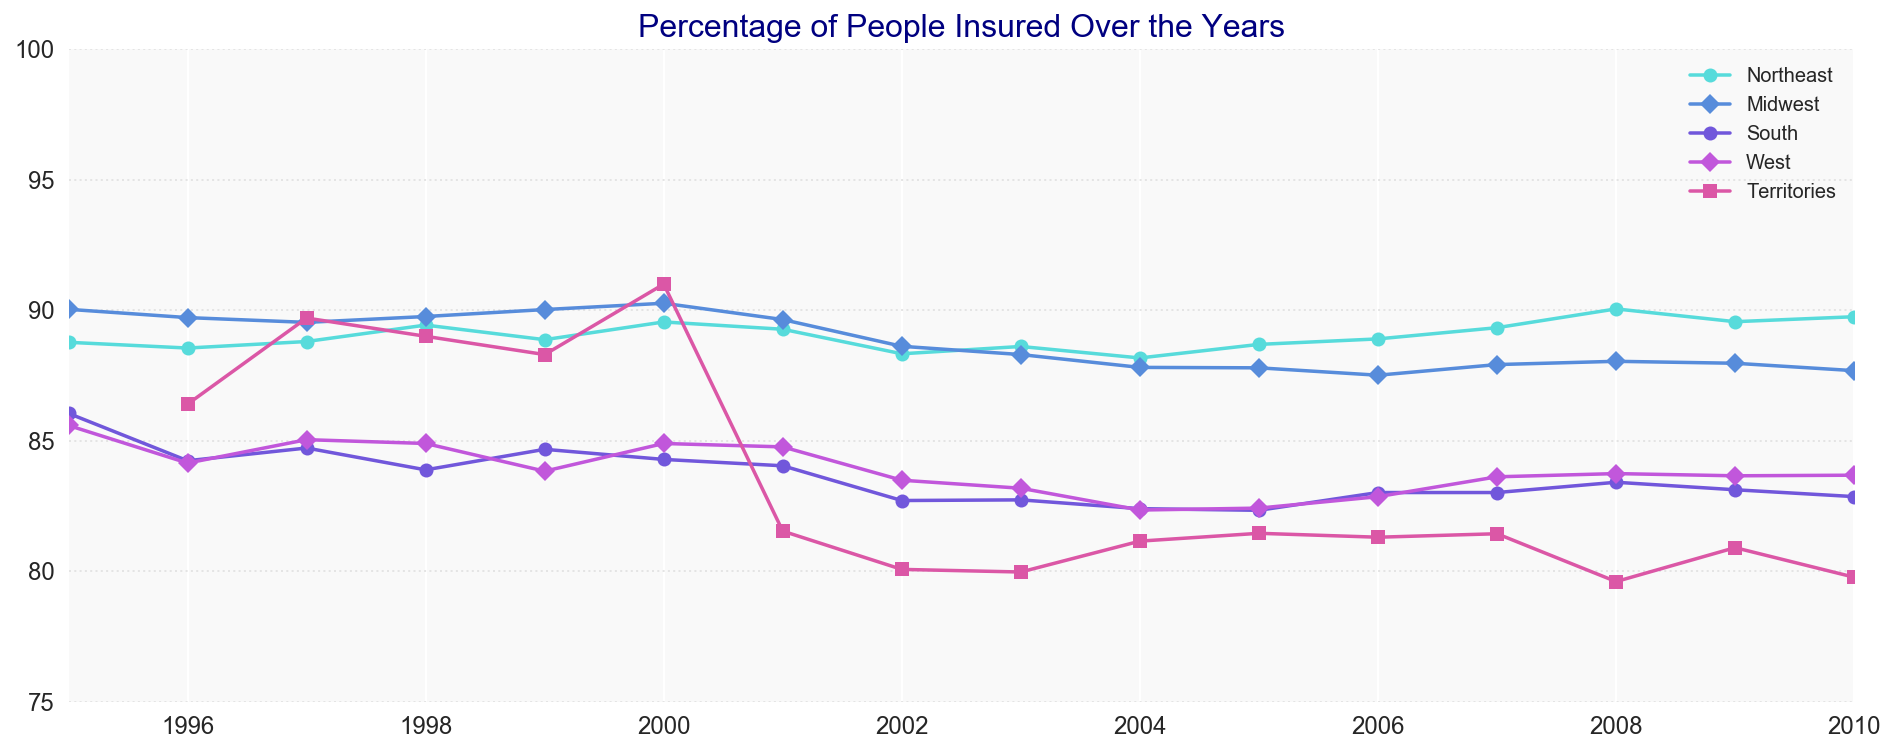

In [28]:
#Create plot with percentage of people who have answered to have some form of insurance (mean per US census region)

fig, ax = plt.subplots(1,1, figsize=(16, 6))

northeast.plot(label='Northeast', marker='o')
midwest.plot(label='Midwest', marker='D')
south.plot(label='South', marker='o')
west.plot(label='West', marker='D')
territories.plot(label='Territories', marker='s')

ax.set_facecolor('#F9F9F9')
ax.grid(color='#E4E4E4', linestyle='dotted', linewidth=1, axis ='y')

plt.ylim(75, 100)
plt.title('Percentage of People Insured Over the Years', fontsize=16, color='navy')
plt.xlabel('')
plt.tick_params(labelsize=12)
plt.legend(loc='upper right');

# Load and process dataset with information after the ACA (1995-2010)

In [29]:
#Source: https://www.kaggle.com/hhs/health-insurance
post_ACA = pd.read_csv('Data/HC_access_afterACA.csv')

In [30]:
post_ACA.tail()

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
47,Washington,14.2%,6.6%,-7.6%,537000,3986000,158245,110476,$238,True,1117576.0,1788536,670960.0,1238649
48,West Virginia,14.6%,6%,-8.6%,156000,976000,33235,29163,$388,True,354544.0,575645,221101.0,423500
49,Wisconsin,9.4%,5.7%,-3.7%,211000,3521000,224208,190542,$332,False,985531.0,1046897,61366.0,1084854
50,Wyoming,14.9%,11.5%,-3.4%,20000,335000,22076,20313,$459,False,67518.0,63583,-3935.0,99128
51,United States,15.5%,9.4%,6.1%,19304000,172292000,11081330,9389609,$291,NaN,56392477.0,73532931,16106157.0,57149984


In [31]:
cols = ['Uninsured Rate (2010)', 'Uninsured Rate (2015)','Uninsured Rate Change (2010-2015)'] #% values

In [32]:
#Remove % from string values
for col in cols:
    post_ACA[col] = post_ACA[col].apply(lambda x: re.sub('%', '', x))

In [33]:
#Remove $ from string values
post_ACA['Average Monthly Tax Credit (2016)'] = \
post_ACA['Average Monthly Tax Credit (2016)'].apply(lambda x: x[1:-1])

In [34]:
#Convert string datatypes to numeric
for col in cols:
    post_ACA[col] = pd.to_numeric(post_ACA[col])
    
post_ACA['Average Monthly Tax Credit (2016)'] = pd.to_numeric(post_ACA['Average Monthly Tax Credit (2016)'])

In [35]:
#Remove trailing whitespace from state names
post_ACA.State = post_ACA.State.apply(lambda x: x.rstrip())

In [36]:
post_ACA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 14 columns):
State                                           52 non-null object
Uninsured Rate (2010)                           52 non-null float64
Uninsured Rate (2015)                           52 non-null float64
Uninsured Rate Change (2010-2015)               52 non-null float64
Health Insurance Coverage Change (2010-2015)    52 non-null int64
Employer Health Insurance Coverage (2015)       52 non-null int64
Marketplace Health Insurance Coverage (2016)    52 non-null int64
Marketplace Tax Credits (2016)                  52 non-null int64
Average Monthly Tax Credit (2016)               52 non-null int64
State Medicaid Expansion (2016)                 51 non-null object
Medicaid Enrollment (2013)                      50 non-null float64
Medicaid Enrollment (2016)                      52 non-null int64
Medicaid Enrollment Change (2013-2016)          50 non-null float64
Medicare Enrollment (2016) 

In [37]:
post_ACA.tail()

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
47,Washington,14.2,6.6,-7.6,537000,3986000,158245,110476,238,True,1117576.0,1788536,670960.0,1238649
48,West Virginia,14.6,6.0,-8.6,156000,976000,33235,29163,388,True,354544.0,575645,221101.0,423500
49,Wisconsin,9.4,5.7,-3.7,211000,3521000,224208,190542,332,False,985531.0,1046897,61366.0,1084854
50,Wyoming,14.9,11.5,-3.4,20000,335000,22076,20313,459,False,67518.0,63583,-3935.0,99128
51,United States,15.5,9.4,6.1,19304000,172292000,11081330,9389609,291,NaN,56392477.0,73532931,16106157.0,57149984


In [38]:
len(sorted(post_ACA.State.unique())) #50 states + DC + United States

52

In [39]:
#Merge state code into dataset
post_ACA = post_ACA.merge(state_codes, how='left', on='State')

In [40]:
#Create column with the total insured population per state. Assign code for United States.
post_ACA.loc[51:,('code')] = 'US'
post_ACA['insured_pop'] = post_ACA.iloc[:,[5,6,11,13]].sum(axis=1)

In [41]:
#Calculate the proportion of enrollment change per state between 2013 and 2016 from the country's 
#total new enrollments for the period.
post_ACA['medicaid_delta'] = (post_ACA['Medicaid Enrollment Change (2013-2016)']/\
post_ACA['Medicaid Enrollment Change (2013-2016)'][51]) *100

## Explore uninsured population data

In [59]:
#States with the largest proportion of uninsured population before ACA (2010)
post_ACA.iloc[:,:4].sort_values(by='Uninsured Rate (2010)', ascending = False)[:19]

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015)
43,Texas,23.7,17.1,-6.6
28,Nevada,22.6,12.3,-10.3
9,Florida,21.3,13.3,-8.0
1,Alaska,19.9,14.9,-5.0
10,Georgia,19.7,13.9,-5.8
31,New Mexico,19.6,10.9,-8.7
36,Oklahoma,18.9,13.9,-5.0
4,California,18.5,8.6,-9.9
24,Mississippi,18.2,12.7,-5.5
18,Louisiana,17.8,11.9,-5.9


In [43]:
#Texas still has the highest rate of uninsured population in the country
post_ACA['Uninsured Rate (2015)'].max()

17.100000000000001

In [44]:
#All states show a drop in uninsured population. Massachusetts had the lowest change in the country...
#and also the lowest rate of uninsured population before and after ACA. Will California follow with SB 562?
post_ACA[post_ACA['Uninsured Rate (2015)'] < 3]

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016),code,insured_pop,medicaid_delta
21,Massachusetts,4.4,2.8,-1.6,107000,4232000,207121,157751,190,True,1296359.0,1684328,387969.0,1252277,MA,7375726,2.408824


In [45]:
#States with the largest decreases in uninsured population after ACA (2015): above the naiton average of -6.1% points
uninsured_rate = post_ACA.ix[:,[1,2,3,-3]].sort_values(by='Uninsured Rate Change (2010-2015)')[:17]\
.sort_values(by='Uninsured Rate (2010)', ascending = False)
uninsured_rate

,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),code
43,23.7,17.1,-6.6,TX
28,22.6,12.3,-10.3,NV
9,21.3,13.3,-8.0,FL
31,19.6,10.9,-8.7,NM
4,18.5,8.6,-9.9,CA
12,17.7,11.0,-6.7,ID
40,17.5,10.9,-6.6,SC
3,17.5,9.5,-8.0,AR
37,17.1,7.0,-10.1,OR
2,16.9,10.8,-6.1,AZ


## Fig2a: Chart showing changes in uninsured population rates before and after ACA

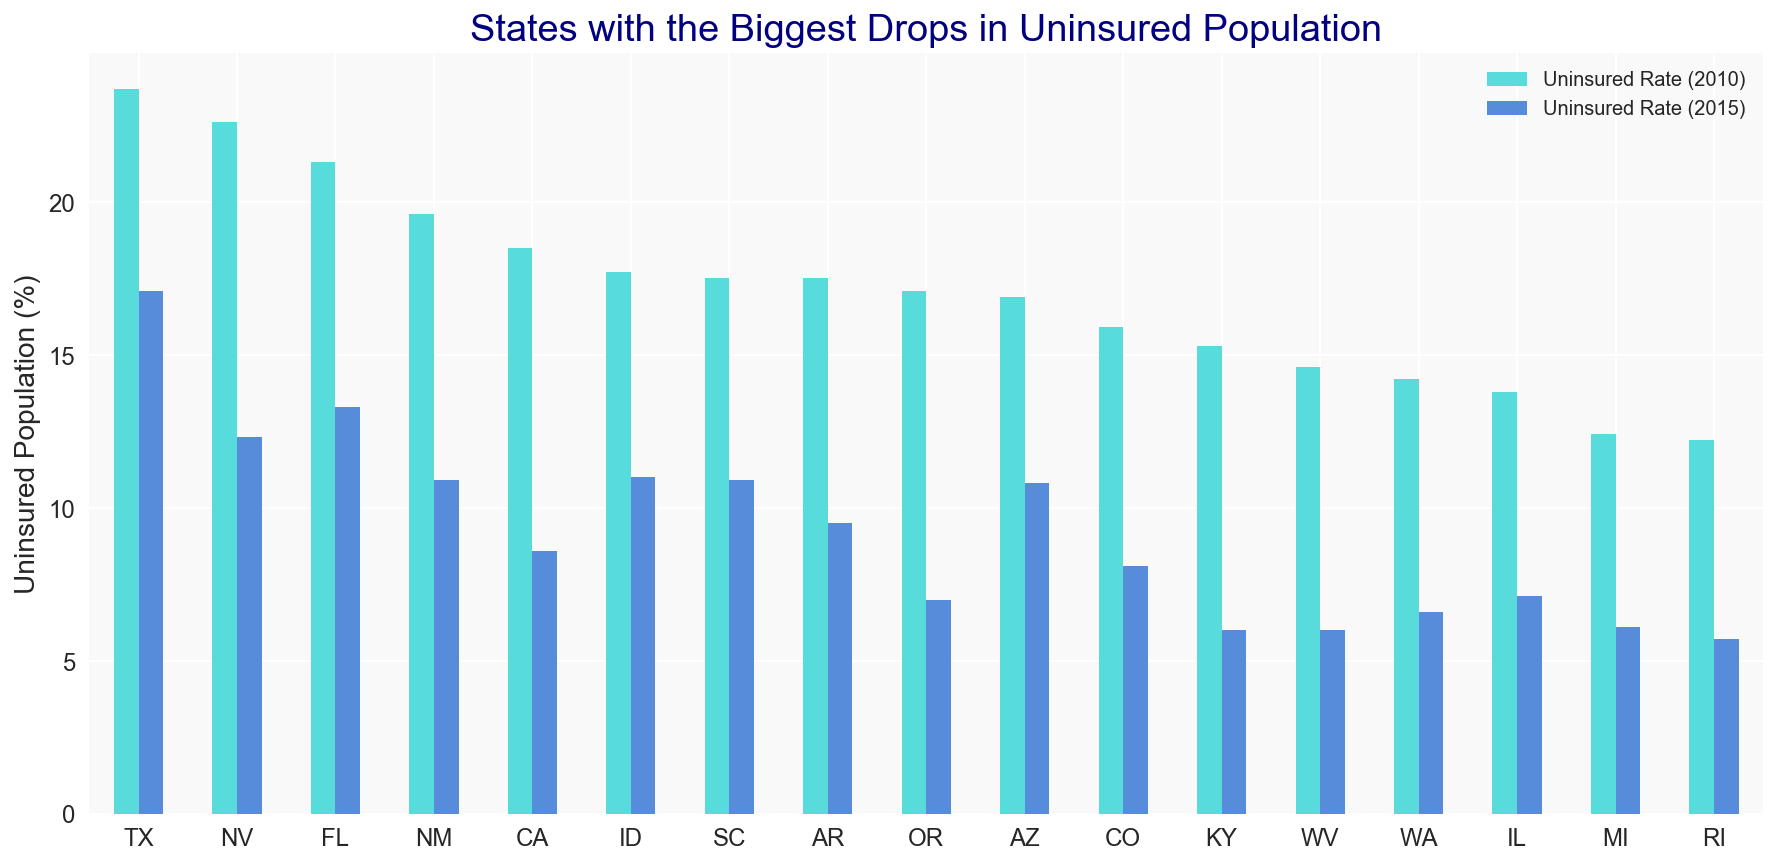

In [60]:
#Create plot
ax = uninsured_rate.iloc[:,:2].plot.bar(figsize = (15,7), fontsize=12, rot=0)
ax.set_facecolor('#F9F9F9')
ax.set_xticklabels(uninsured_rate.code)

plt.ylabel('Uninsured Population (%)', fontsize = 14)
plt.title('States with the Biggest Drops in Uninsured Population', fontsize=19, color='navy');

## Fig2b: Interactive chart 

In [62]:
#Equivalent interactive version
#(0,120,171) - big sky blue; (64, 224, 208) - turquoise blue

trace2010 = go.Bar(
    x=uninsured_rate['code'],
    y=uninsured_rate['Uninsured Rate (2010)'],
    name='2010 - Uninsured Rate',
    marker=dict(
        color='rgb(64, 224, 208)'
    )
)
trace2015 = go.Bar(
    x=uninsured_rate['code'],
    y=uninsured_rate['Uninsured Rate (2015)'],
    name='2015 - Uninsured Rate',
    marker=dict(
        color='rgb(0, 120, 171)'
    )
)
data = [trace2010, trace2015]
layout = go.Layout(
    title='States with the Biggest Drops in Uninsured Population',
    xaxis=dict(
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Uninsured Population (%)',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='uninsured-pop-drop')

Aw, snap! We don't have an account for ''. Want to try again? You can authenticate with your email address or username. Sign in is not case sensitive.

Don't have an account? plot.ly

Questions? support@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

## Explore data about sources of insurance

In [48]:
#List dataset columns with insured population breakdown by source of insurance
cols = [u'code', u'Employer Health Insurance Coverage (2015)',
       u'Marketplace Health Insurance Coverage (2016)',
       u'Medicaid Enrollment (2016)', u'Medicare Enrollment (2016)',
       u'insured_pop']

In [49]:
#Select data with enrollment per source of insurance. 
insurance_type = post_ACA.loc[:,(cols)]

#Calculate total insured population and share of government coverage for each state.
insurance_type['single_payer'] = insurance_type.iloc[:,[3,4]].sum(1)/insurance_type.loc[:,('insured_pop')]
insurance_type['market'] = 1- insurance_type.single_payer

#Breakdown for each source of insurance.
insurance_type['prop_employer'] = \
insurance_type['Employer Health Insurance Coverage (2015)']/insurance_type.insured_pop

insurance_type['prop_marketplace'] = \
insurance_type['Marketplace Health Insurance Coverage (2016)']/insurance_type.insured_pop

insurance_type['prop_medicaid'] = insurance_type['Medicaid Enrollment (2016)']/insurance_type.insured_pop
insurance_type['prop_medicare'] = insurance_type['Medicare Enrollment (2016)']/insurance_type.insured_pop


insurance_type.tail()

,code,Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Medicaid Enrollment (2016),Medicare Enrollment (2016),insured_pop,single_payer,market,prop_employer,prop_marketplace,prop_medicaid,prop_medicare
47,WA,3986000,158245,1788536,1238649,7171430,0.422117,0.577883,0.555817,0.022066,0.249397,0.172720
48,WV,976000,33235,575645,423500,2008380,0.497488,0.502512,0.485964,0.016548,0.286622,0.210866
49,WI,3521000,224208,1046897,1084854,5876959,0.362730,0.637270,0.599119,0.038150,0.178136,0.184594
50,WY,335000,22076,63583,99128,519787,0.313034,0.686966,0.644495,0.042471,0.122325,0.190709
51,US,172292000,11081330,73532931,57149984,314056245,0.416113,0.583887,0.548602,0.035285,0.234139,0.181974


In [50]:
insurance_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 12 columns):
code                                            52 non-null object
Employer Health Insurance Coverage (2015)       52 non-null int64
Marketplace Health Insurance Coverage (2016)    52 non-null int64
Medicaid Enrollment (2016)                      52 non-null int64
Medicare Enrollment (2016)                      52 non-null int64
insured_pop                                     52 non-null int64
single_payer                                    52 non-null float64
market                                          52 non-null float64
prop_employer                                   52 non-null float64
prop_marketplace                                52 non-null float64
prop_medicaid                                   52 non-null float64
prop_medicare                                   52 non-null float64
dtypes: float64(6), int64(5), object(1)
memory usage: 7.8+ KB


In [51]:
#Print stats for US:
insurance_type.iloc[:-1].single_payer.describe() #mean = ~ 41%

count    51.000000
mean      0.407070
std       0.055971
min       0.246141
25%       0.370110
50%       0.408761
75%       0.442417
max       0.553056
Name: single_payer, dtype: float64

In [52]:
#States where the government already covers more than 50% of the insured population
insurance_type[insurance_type.single_payer >= 0.50]

,code,Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Medicaid Enrollment (2016),Medicare Enrollment (2016),insured_pop,single_payer,market,prop_employer,prop_marketplace,prop_medicaid,prop_medicare
3,AR,1365000,63357,920194,606146,2954697,0.516581,0.483419,0.461976,0.021443,0.311434,0.205147
31,NM,884000,47497,766732,385918,2084147,0.553056,0.446944,0.424154,0.022790,0.367888,0.185168


In [53]:
#State where the government represents the lowest propertion of insurance source
insurance_type[insurance_type.single_payer < 0.25]

,code,Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Medicaid Enrollment (2016),Medicare Enrollment (2016),insured_pop,single_payer,market,prop_employer,prop_marketplace,prop_medicaid,prop_medicare
44,UT,1897000,164415,314182,358887,2734484,0.246141,0.753859,0.693732,0.060127,0.114896,0.131245


## Fig3a: Chart showing states where the government covers > 40% of the population

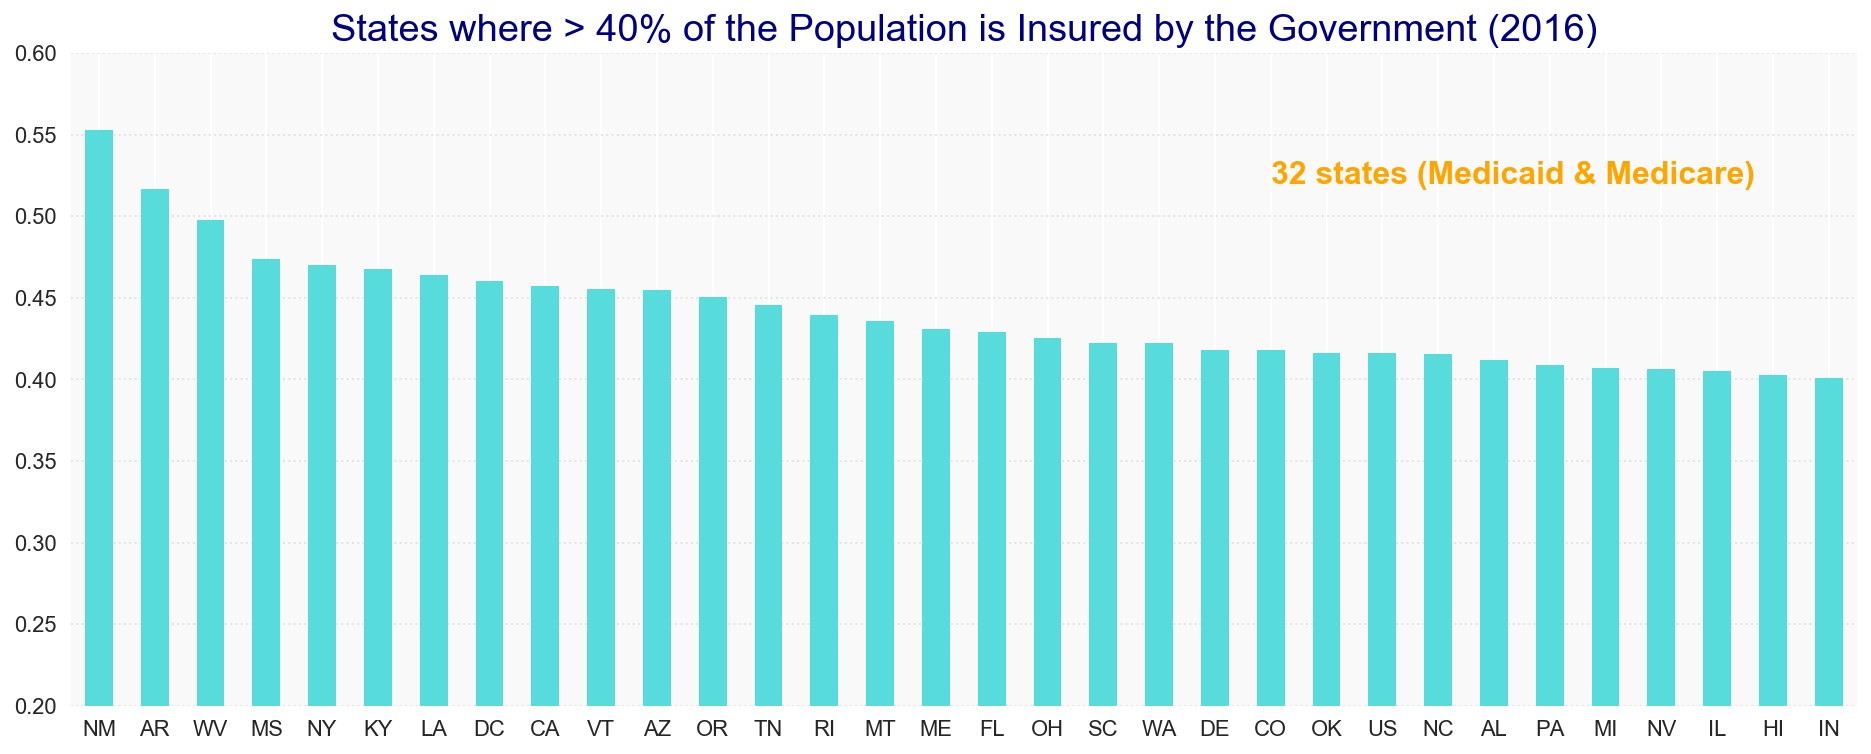

In [54]:
#Create plot. National mean = 41% of the population covered by Medicaid or Medicare (26 states above mean).
ax = insurance_type[insurance_type.single_payer > .4].single_payer.sort_values(ascending=False).\
plot.bar(figsize=(16,6), fontsize=11, rot=0)

labels = insurance_type.sort_values(by='single_payer', ascending=False)['code']
ax.set_xticklabels(labels)
ax.set_facecolor('#F9F9F9')
ax.grid(color='#E4E4E4', linestyle='dotted', linewidth=1, axis ='y')

plt.text(21, .52, '32 states (Medicaid & Medicare)', color='orange', size= 16, weight ='bold')
plt.ylim(.2,.6)
plt.title('States where > 40% of the Population is Insured by the Government (2016)', fontsize=19, color='navy');

## Fig3b: Chart showing the proportion of government insurance coverage per state

In [55]:
#Scale size of insured population to be used as bubble dimension

#color= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
size = insurance_type.iloc[:-1, :].insured_pop/500000. #disregard last row which is data for the US
size.min(), size.max()

(1.039574, 77.280572000000006)

In [61]:
#Bubble chart: proportion of single payer per state (similar to Fig3a but showing all states). Nationwide mean: 41%
#The bubble size is proportional to the total insured population in each state.

trace = go.Scatter (x = insurance_type.iloc[:-1, :].code, 
                    y = insurance_type.iloc[:-1, :].single_payer,
                    text = 'Proportion of Medicare + Medicaid',
                    marker = dict(size = size, 
                                  color=range(len(insurance_type)-1), 
                                  opacity= 0.7, 
                                  colorscale='Viridis'), 
                    mode = 'markers')

layout = dict(
    title = 'Proportion of Insured Population Covered by the Government<br>(bubble size is proportional to population)',
    xaxis=dict(tickangle=-90)
)


data=[trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='proportion-single-payer')

TypeError: Object of type 'range' is not JSON serializable

## Fig4a: Chart with breakdown of source of coverage for top 10 states by insured population

In [ ]:
#Select top 10 states by insured population
top10_pop = insurance_type.sort_values(by='insured_pop', ascending=False).head(11)

In [ ]:
#Create function to format tick values
def millions_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of millions with one decimal, and M in lieu of 6 zeros.
    """
    return '{:.0f}{}'.format(x * 1e-6, 'M') 

In [ ]:
#Create plot (data is mostly for 2016, see legend)
ax = top10_pop.iloc[1:,(1,3,4,2)].plot.bar(stacked=True,figsize=(16,6), fontsize=11, rot=0)

formatter = FuncFormatter(millions_format)
ax.yaxis.set_major_formatter(formatter)

top10 = ['CA', 'TX', 'NY', 'FL', 'PA', 'IL', 'OH', 'MI', 'NC', 'GA']
ax.set_xticklabels(top10)

ax.set_facecolor('#F9F9F9')

plt.title('Source of Coverage Breakdown for the Top 10 States by Insured Population', fontsize=19, color='navy');

## Fig4b: Interactive version of stacked bar chart above to aid visualization

In [ ]:
top10_pop

In [ ]:
#Create plot. Note: there is a daily limit to the number of Plotly's API calls. An error will be raised beyond limit.
#Color palette source: http://colrd.com/palette/27656/ 
#Baseline: #55% employer, 23.5% medicaid, 3.5% marketplace, 18% medicare

data = [
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,1],
        name = 'Employer',
        text = top10_pop.prop_employer.iloc[1:].apply(lambda x: '{:,.0f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(161,173,167)'
        ),
    ),
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,3],
        name = 'Medicaid',
        text = top10_pop.prop_medicaid.iloc[1:].apply(lambda x: '{:,.0f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(62,152,195)'
        ),
    ),
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,4],
        name = 'Medicare',
        text = top10_pop.prop_medicare.iloc[1:].apply(lambda x: '{:,.0f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(13,96,136)'
        ),
    ),
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,2],
        name = 'Marketplace',
        text = top10_pop.prop_marketplace.iloc[1:].apply(lambda x: '{:,.1f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(108,195,9)'
        ),
    )

]

layout = go.Layout(
    barmode='stack',
    title='Source of Coverage Breakdown for the Top 10 States by Insured Population'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='insurance-source-breakdown')

## Explore Medicare data

In [ ]:
#Select Medicare data
medicare = insurance_type[['code', 'Medicare Enrollment (2016)', 'insured_pop']]\
.sort_values(by='Medicare Enrollment (2016)', ascending=False).iloc[1:,:]

In [ ]:
#Get top 10 states by number of Medicare enrollees
medicare_top10 = medicare.head(10).copy()

In [ ]:
#Estimated total population 65 years or older per state in 2015 (source: US Census website)
pop_65 = pd.Series([5188754, 3942468, 3225168, 2964315, 2179788, 1842952, 1830277, 1570671, 1516824, 1304924], 
                  index= medicare_top10.index)

In [ ]:
#Load total population for top 10 states (source: US Census website, downloaded as pop_65+_perState.csv)
popTop10 = pd.read_csv('Data/pop_2016.csv')
popTop10.index = medicare_top10.index
popTop10.head()

In [ ]:
#Add columns with % of insured population covered by Medicare, population 65 and over, and total population.
medicare_top10.loc[:,'total_pop'] = popTop10.pop_2016
medicare_top10.loc[:,'pop_over_65'] = pop_65
medicare_top10['%Medicare'] = 100*medicare_top10['Medicare Enrollment (2016)']/medicare_top10.total_pop
medicare_top10.loc[:,'perc_over_65'] = 100*medicare_top10.pop_over_65/medicare_top10.total_pop

In [ ]:
#The top 10 states represent 51% of all Medicare enrollees
US_medicare_total = insurance_type['Medicare Enrollment (2016)'][51]
medicare_top10['Medicare Enrollment (2016)'].sum()*1./US_medicare_total

In [ ]:
#States with the largest numbers of individuals insured by Medicare are also the states with the largest 
#population aged 65 or older. The top 10 states represent 51% of all Medicare enrollees.
medicare_top10

## Fig5: Chart showing Top 10 Medicare Markets

In [ ]:
#Create text to show when hovering over map
medicare_top10['text'] = medicare_top10['code'] + '<br>' +\
'Total Population over 65: ' + medicare_top10['perc_over_65'].apply(lambda x: '{:,.1f}'.format(x)) + '%'+'<br>' +\
'Total Population on Medicare: '+ medicare_top10['%Medicare'].apply(lambda x: '{:,.1f}'.format(x)) + '%'

In [ ]:
medicare_top10.text[4]

In [ ]:
#Visualize Top 10 Medicare markets (by number of enrollees), by number of population 65 years or older.

trace0 = go.Bar(
    x=medicare_top10.code,
    y=medicare_top10['Medicare Enrollment (2016)'],
    text=medicare_top10['text'],
    marker=dict(
        color=range(len(medicare_top10.code)),
        colorscale='Viridis'
    ),
    opacity=0.7
)

data = [trace0]
layout = go.Layout(
    title='Top 10 Medicare Markets by Number of Enrollees (2016)',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='top10-medicare-markets')

## Explore Medicaid data

In [ ]:
#Check states with the largest proportion (> 2.5%) of additional Medicaid enrollees between 2013 and 2016.
post_ACA[post_ACA['medicaid_delta'] >2.5][['medicaid_delta', 'code', 'State Medicaid Expansion (2016)']].\
sort_values(by='medicaid_delta', ascending=False)[1:]

In [ ]:
#These 3 states actually had a decrease in the number of enrollments in Medicaid.
post_ACA[post_ACA['Medicaid Enrollment Change (2013-2016)'] < 0]

## Fig6: Map showing Medicaid enrollment changes throughout the country

In [ ]:
#Create a color scale
#palette source: http://colrd.com/palette/19057/
scl3 = [[0.0, 'rgb(255,255,217)'],[0.25, 'rgb(237,248,177)'],[.5, 'rgb(127,205,187)'], [1.0, 'rgb(12,44,132)']]

In [ ]:
#Create text to show when hovering over map
post_ACA['text'] = post_ACA['State'] + '<br>' +\
'Expanded Medicaid: ' + post_ACA['State Medicaid Expansion (2016)'].astype(str) + '<br>' +\
'Medicaid Enrollment in 2016: '+ post_ACA['Medicaid Enrollment (2016)'].apply(lambda x: '{:,.0f}'.format(x)) + '<br>'+\
'Enrollment Change from 2013: '+ post_ACA['Medicaid Enrollment Change (2013-2016)'].apply(lambda x: '{:,.0f}'.format(x))

In [ ]:
#Check text string
post_ACA['text'][0]

In [ ]:
#Apply log to the color scale so that there is more contrast
z = post_ACA.medicaid_delta.apply(lambda x: np.log(x))

In [ ]:
#Create the choropleth using Plotly Python API.

data = [dict(
        type='choropleth',
        colorscale = scl3,
        autocolorscale = False,
    showscale = False,
        locations = post_ACA['code'],
        z = z,
        locationmode = 'USA-states',
    hoverinfo = 'text',
        text = post_ACA['text'],
        marker = dict(
            line = dict(
                color = 'rgb(255,255,255)',
                width = 1.5
            )),
        #colorbar = dict(
        #    title = "% of New Medicaid Enrollees from 2013")
        )]

layout = dict(
        title = 'Change in Medicaid Enrollment by State between 2013 and 2016<br>(hover for actual numbers)',
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='medicaid-cloropleth-USA')

## Fig7: Closing the Gap: Health Insurance Coverage Before and After the ACA

In [ ]:
subset.head(3) #review historic data (pre-ACA)

In [ ]:
#Create list with (year, % uninsured population) tuples for every 5 years
uninsured = []
years = [1995, 2000, 2005]

for y in years:
    uninsured.append((y, subset[subset.Year==y].No.mean()))
    
uninsured.append((2010, post_ACA['Uninsured Rate (2010)'][51]))
uninsured.append((2015, post_ACA['Uninsured Rate (2015)'][51]))

dict(uninsured)

In [ ]:
#Create summary dataframe containing data about population and GDP for each year.
#Source of population estimates: US Census Bureau via http://www.multpl.com/united-states-population/table

gdp_per_capita = [38.01, 44.63, 47.96, 47.86, 51.22] #chained to 2009 dollars (inflation adjusted)
pop_millions = [266.28, 282.16, 295.52, 308.11, 319.7]

summary_df = pd.DataFrame(uninsured, columns = ['year', 'uninsured_%'])
summary_df['gdp_thousands_$'] = pd.Series(gdp_per_capita)
summary_df['pop_millions'] = pd.Series(pop_millions)
summary_df['pop_insured'] = ((100 - summary_df['uninsured_%'])/100.0)* summary_df.pop_millions

summary_df

In [ ]:
#Define function to automatically add annotated labels on bar plots.

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)        
        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
    return None

In [ ]:
#Define arguments for annotate_labels function to be used to create the plot with data befofe and after the ACA.
labels_list = [str(x) + '%' for x in summary_df['uninsured_%'].values.round(1)]
kwargs = {'fontsize': 13, 'ha':'center', 'va': 'bottom', 'weight': 'bold'}

In [ ]:
#Create comparison plot (before and after ACA (2015))
fig, ax = plt.subplots(figsize=(16,6))

#Bars representing total US population at each year
ax.bar(summary_df.year, summary_df.pop_millions, color='#00E5EE', width=3, 
       label='Uninsured Proportion from Total Population')
ax.set_facecolor('#f6f6f6')
ax.tick_params(labelsize=14)
ax.legend(loc='upper left', fontsize=12)
plt.ylim(0,350)
plt.ylabel('Population (Millions)', fontsize=13)

#Superimposing bars with total insured population in the US
ax2 = ax.twinx()
ax2.bar(summary_df.year, summary_df.pop_insured, color = '#003366', width=2.9)
ax2.get_yaxis().set_ticks([])
annotate_labels(ax2, labels_list, **kwargs)
plt.ylim(0,350);

The ACA has not only reverted the trending growth in the percentage of uninsured population, but it has also reduced it to the lowest level in at least the last 20 years.

In [ ]:
#turquoise blues: #00C5CD #00CED1 #00E5EE #00FFEF 
#dark blue: #003366 

#rgb(26,48,111)    rgb(194,212,248)    rgb(70,123,208)    rgb(116,193,245)   
#http://colrd.com/palette/22453/ dark to light blues
 
#rgb(43,67,79), rgb(99,130,112), rgb(188,201,142), rgb(237,224,89) gray to yellow
#http://colrd.com/palette/21852/